In [78]:
import sys
from pathlib import Path

# So "from helpers import ..." works no matter where the kernel was started
_cal = Path.cwd() / 'calibration'
if _cal.exists() and (_cal / 'helpers.py').exists() and str(_cal) not in sys.path:
    sys.path.insert(0, str(_cal))
elif (Path.cwd() / 'helpers.py').exists() and str(Path.cwd()) not in sys.path:
    sys.path.insert(0, str(Path.cwd()))

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, gamma, nbinom, trim_mean
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from math import inf
from itertools import islice
from google.cloud import bigquery, storage
from helpers import *

# For BigQuery queries
project_id = 'sc-bq-ds-adhoc'
client = bigquery.Client(project=project_id)

In [2]:
table_names = {
    'one_day_pop': 'all_traffic_without_filters_20251201',
    'one_day_sample': 'all_traffic_without_filters_seeds_20251201',
    'one_week_pop': 'global_20260101_20260107',
    'one_week_sample': 'ab_data_20260101_20260107'
}

In [3]:
#Overall
df_all_1201 = calculate_sla_metrics(table_name = table_names['one_day_pop'])
df_sampled_1201 = calculate_sla_metrics(table_name = table_names['one_day_sample'], is_sample=True)

E0000 00:00:1771529619.029672 4406198 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1771530158.046350 4406198 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [60]:
df_all_1201['calibration'] = np.where(
    df_all_1201['conversions'] == 0,
    0,
    df_all_1201['conversions_pred'] / df_all_1201['conversions']
)

In [4]:
#GBB - app intall
df_all_app_install_1201 = calculate_sla_metrics(table_name = table_names['one_day_pop'], gbb_filter = 'APP_INSTALLS')
df_sampled_app_install_1201 = calculate_sla_metrics(table_name = table_names['one_day_sample'], gbb_filter = 'APP_INSTALLS', is_sample=True)

E0000 00:00:1771530438.112482 4406198 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.
E0000 00:00:1771530601.816526 4406198 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [61]:
df_all_app_install_1201['calibration'] = np.where(
    df_all_app_install_1201['conversions'] == 0,
    0,
    df_all_app_install_1201['conversions_pred'] / df_all_app_install_1201['conversions']
)

# Sampling Variance

In [62]:
# Aggregate sampled data by sim_id
df_sampled_1201_agg = df_sampled_1201.groupby('sim_id').agg({
    'revenue': 'sum',
    'impressions': 'sum',
    'rev_sla': 'sum',
    'conversions': 'sum',
    'conversions_pred': 'sum'
}).reset_index()

df_sampled_1201_agg['pct_rev_sla'] = df_sampled_1201_agg['rev_sla'] / df_sampled_1201_agg['revenue']
df_sampled_1201_agg['calibration'] = df_sampled_1201_agg['conversions_pred'] / df_sampled_1201_agg['conversions'] 

# Population metrics (single values)
pop_pct_rev_sla = df_all_1201['rev_sla'].sum() / df_all_1201['revenue'].sum()
pop_calibration = df_all_1201['conversions_pred'].sum() / df_all_1201['conversions'].sum()

print(f"Population pct_rev_sla: {pop_pct_rev_sla:.4f}")
print(f"Population conversions: {pop_calibration:,.4f}")
print(f"Number of simulations: {len(df_sampled_1201_agg)}")

# App install: aggregate and population metrics
df_sampled_app_install_1201_agg = df_sampled_app_install_1201.groupby('sim_id').agg({
    'revenue': 'sum',
    'impressions': 'sum',
    'rev_sla': 'sum',
    'conversions': 'sum',
    'conversions_pred': 'sum'
}).reset_index()
df_sampled_app_install_1201_agg['pct_rev_sla'] = df_sampled_app_install_1201_agg['rev_sla'] / df_sampled_app_install_1201_agg['revenue']
df_sampled_app_install_1201_agg['calibration'] = df_sampled_app_install_1201_agg['conversions_pred'] / df_sampled_app_install_1201_agg['conversions']
pop_pct_rev_sla_app = df_all_app_install_1201['rev_sla'].sum() / df_all_app_install_1201['revenue'].sum()
pop_calibration_app = df_all_app_install_1201['conversions_pred'].sum() / df_all_app_install_1201['conversions'].sum()
print(f"App install - Population pct_rev_sla: {pop_pct_rev_sla_app:.4f}, calibration: {pop_calibration_app:,.4f}, sims: {len(df_sampled_app_install_1201_agg)}")


Population pct_rev_sla: 0.3371
Population conversions: 0.8886
Number of simulations: 1000
App install - Population pct_rev_sla: 0.2786, calibration: 1.3567, sims: 1000


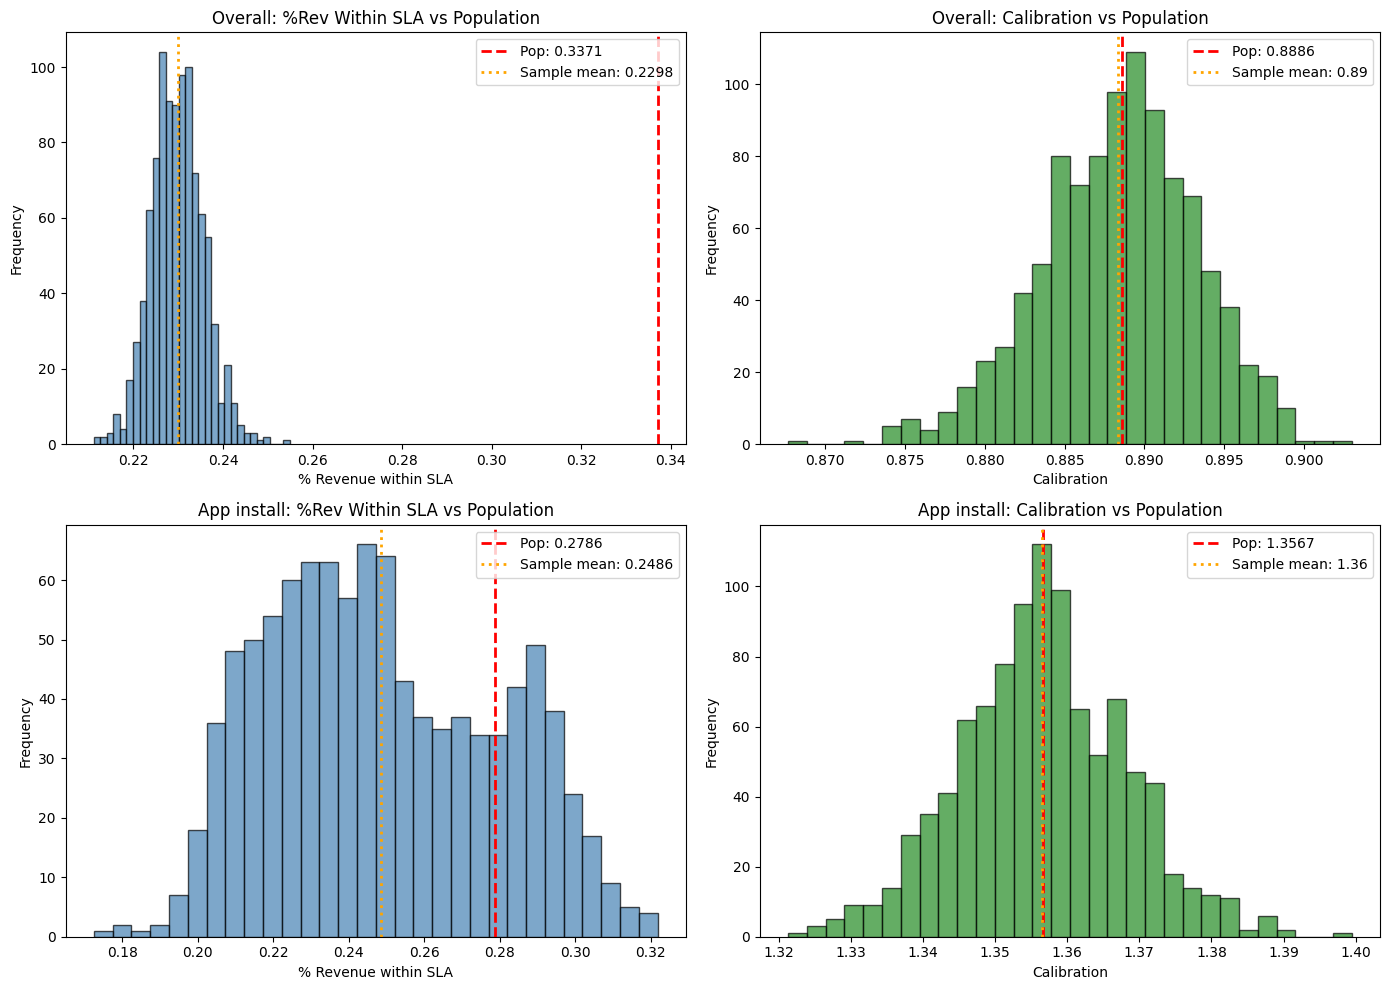

=== Overall ===
pct_rev_sla:  Pop 0.3371, Sample mean 0.2298
calibration:  Pop 0.8886, Sample mean 0.8884
=== App install ===
pct_rev_sla:  Pop 0.2786, Sample mean 0.2486
calibration:  Pop 1.3567, Sample mean 1.3566


In [63]:
# Plot: Sample distributions vs Population metrics (original | app_install)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Original: pct_rev_sla ---
ax1 = axes[0, 0]
ax1.hist(df_sampled_1201_agg['pct_rev_sla'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(pop_pct_rev_sla, color='red', linestyle='--', linewidth=2, label=f'Pop: {pop_pct_rev_sla:.4f}')
ax1.axvline(df_sampled_1201_agg['pct_rev_sla'].mean(), color='orange', linestyle=':', linewidth=2, label=f'Sample mean: {df_sampled_1201_agg["pct_rev_sla"].mean():.4f}')
ax1.set_xlabel('% Revenue within SLA')
ax1.set_ylabel('Frequency')
ax1.set_title('Overall: %Rev Within SLA vs Population')
ax1.legend(loc='upper right')

# --- Original: calibration ---
ax2 = axes[0, 1]
ax2.hist(df_sampled_1201_agg['calibration'], bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
ax2.axvline(pop_calibration, color='red', linestyle='--', linewidth=2, label=f'Pop: {pop_calibration:,.4f}')
ax2.axvline(df_sampled_1201_agg['calibration'].mean(), color='orange', linestyle=':', linewidth=2, label=f'Sample mean: {df_sampled_1201_agg["calibration"].mean():,.2f}')
ax2.set_xlabel('Calibration')
ax2.set_ylabel('Frequency')
ax2.set_title('Overall: Calibration vs Population')
ax2.legend(loc='upper right')

# --- App install: pct_rev_sla ---
ax3 = axes[1, 0]
ax3.hist(df_sampled_app_install_1201_agg['pct_rev_sla'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax3.axvline(pop_pct_rev_sla_app, color='red', linestyle='--', linewidth=2, label=f'Pop: {pop_pct_rev_sla_app:.4f}')
ax3.axvline(df_sampled_app_install_1201_agg['pct_rev_sla'].mean(), color='orange', linestyle=':', linewidth=2, label=f'Sample mean: {df_sampled_app_install_1201_agg["pct_rev_sla"].mean():.4f}')
ax3.set_xlabel('% Revenue within SLA')
ax3.set_ylabel('Frequency')
ax3.set_title('App install: %Rev Within SLA vs Population')
ax3.legend(loc='upper right')

# --- App install: calibration ---
ax4 = axes[1, 1]
ax4.hist(df_sampled_app_install_1201_agg['calibration'], bins=30, edgecolor='black', alpha=0.7, color='forestgreen')
ax4.axvline(pop_calibration_app, color='red', linestyle='--', linewidth=2, label=f'Pop: {pop_calibration_app:,.4f}')
ax4.axvline(df_sampled_app_install_1201_agg['calibration'].mean(), color='orange', linestyle=':', linewidth=2, label=f'Sample mean: {df_sampled_app_install_1201_agg["calibration"].mean():,.2f}')
ax4.set_xlabel('Calibration')
ax4.set_ylabel('Frequency')
ax4.set_title('App install: Calibration vs Population')
ax4.legend(loc='upper right')

plt.tight_layout()
plt.show()

print("=== Overall ===")
print(f"pct_rev_sla:  Pop {pop_pct_rev_sla:.4f}, Sample mean {df_sampled_1201_agg['pct_rev_sla'].mean():.4f}")
print(f"calibration:  Pop {pop_calibration:,.4f}, Sample mean {df_sampled_1201_agg['calibration'].mean():,.4f}")
print("=== App install ===")
print(f"pct_rev_sla:  Pop {pop_pct_rev_sla_app:.4f}, Sample mean {df_sampled_app_install_1201_agg['pct_rev_sla'].mean():.4f}")
print(f"calibration:  Pop {pop_calibration_app:,.4f}, Sample mean {df_sampled_app_install_1201_agg['calibration'].mean():,.4f}")

In [64]:
def calculate_mean_and_half_ci_percentile(data, confidence=0.95):
    mean = data.mean()
    lower_pct = (1 - confidence) / 2 * 100
    upper_pct = (1 + confidence) / 2 * 100
    ci_lower = np.percentile(data, lower_pct)
    ci_upper = np.percentile(data, upper_pct)
    ci_length = (ci_upper - ci_lower)
    half_ci = ci_length / 2
    return mean, ci_length, half_ci

# Original
mean_pct, ci_length_pct, half_ci_pct = calculate_mean_and_half_ci_percentile(df_sampled_1201_agg['pct_rev_sla'])
mean_calibration, ci_length_calibration, half_ci_calibration = calculate_mean_and_half_ci_percentile(df_sampled_1201_agg['calibration'])
print("=== Original ===")
print(f"pct_rev_sla:  {mean_pct:.4f} ± {half_ci_pct:.4f}")
print(f"calibration:  {mean_calibration:,.4f} ± {half_ci_calibration:,.4f}")
print(f"Relative half CI: pct_rev_sla {ci_length_pct/mean_pct:.2%}, calibration {ci_length_calibration/mean_calibration:.2%}")

# App install
mean_pct_app, ci_len_pct_app, half_ci_pct_app = calculate_mean_and_half_ci_percentile(df_sampled_app_install_1201_agg['pct_rev_sla'])
mean_cal_app, ci_len_cal_app, half_ci_cal_app = calculate_mean_and_half_ci_percentile(df_sampled_app_install_1201_agg['calibration'])
print("\n=== App install ===")
print(f"pct_rev_sla:  {mean_pct_app:.4f} ± {half_ci_pct_app:.4f}")
print(f"calibration:  {mean_cal_app:,.4f} ± {half_ci_cal_app:,.4f}")
print(f"Relative half CI: pct_rev_sla {ci_len_pct_app/mean_pct_app:.2%}, calibration {ci_len_cal_app/mean_cal_app:.2%}")


=== Original ===
pct_rev_sla:  0.2298 ± 0.0114
calibration:  0.8884 ± 0.0098
Relative half CI: pct_rev_sla 9.88%, calibration 2.20%

=== App install ===
pct_rev_sla:  0.2486 ± 0.0512
calibration:  1.3566 ± 0.0230
Relative half CI: pct_rev_sla 41.21%, calibration 3.39%


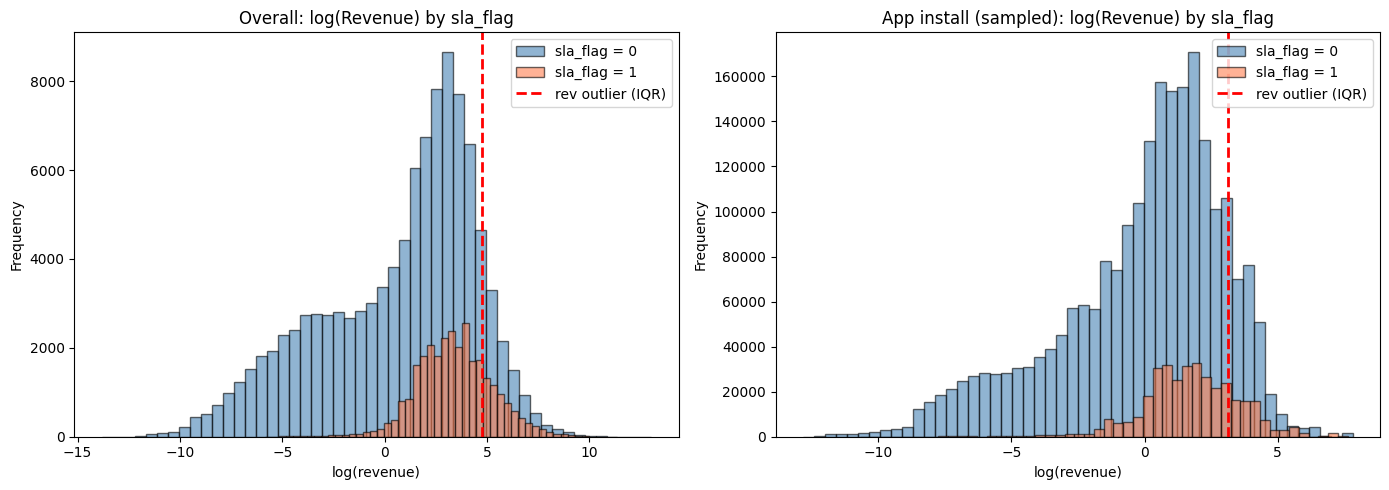

In [65]:
# Plot: log(Revenue) by sla_flag with rev outlier (IQR) — df_all_1201 | df_sampled_app_install_1201
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, df, title in [(axes[0], df_all_1201, 'Overall'), (axes[1], df_sampled_app_install_1201, 'App install (sampled)')]:
    rev0 = df.loc[df['sla_flag'] == 0, 'revenue']
    rev1 = df.loc[df['sla_flag'] == 1, 'revenue']
    log_rev0 = np.log(rev0+1e-6)
    log_rev1 = np.log(rev1+1e-6)
    ax.hist(log_rev0, bins=50, alpha=0.6, label='sla_flag = 0', color='steelblue', edgecolor='black')
    ax.hist(log_rev1, bins=50, alpha=0.6, label='sla_flag = 1', color='coral', edgecolor='black')
    rev = df.loc[df['revenue'] > 0, 'revenue']
    q1, q3 = np.percentile(rev, [25, 75])
    iqr = q3 - q1
    upper_rev = q3 + 1.5 * iqr
    ax.axvline(np.log(upper_rev), color='red', linestyle='--', linewidth=2, label='rev outlier (IQR)')
    ax.set_xlabel('log(revenue)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{title}: log(Revenue) by sla_flag')
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


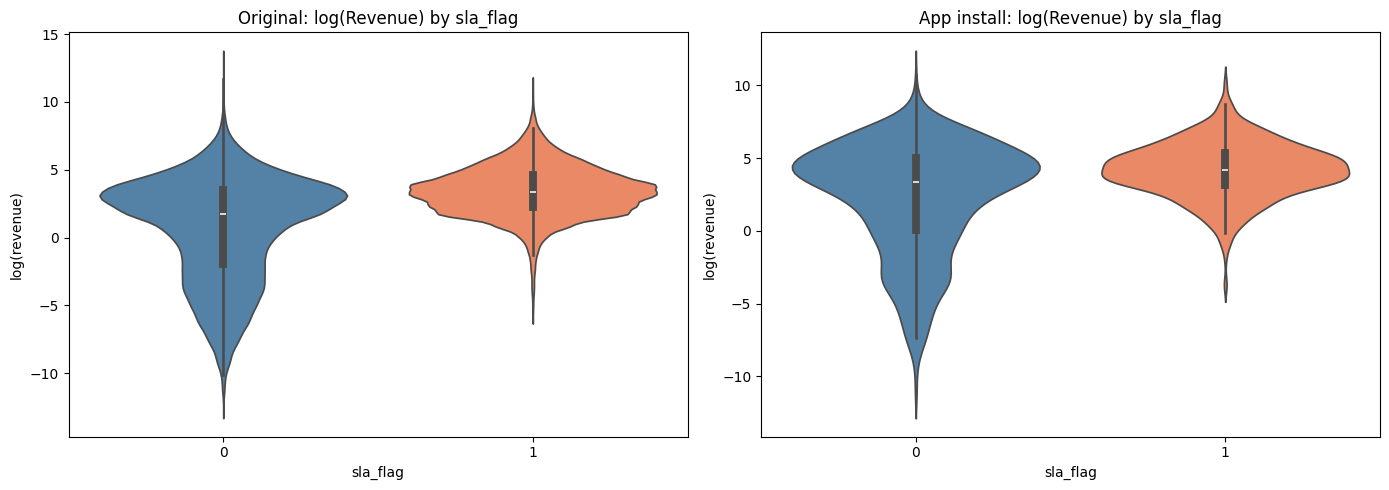

In [66]:
# Violin: log(revenue) by sla_flag (original | app_install)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_plot = df_all_1201.copy()
df_plot['log_revenue'] = np.log(df_plot['revenue'])
sns.violinplot(data=df_plot, x='sla_flag', y='log_revenue', palette={'0': 'steelblue', '1': 'coral'}, ax=axes[0])
axes[0].set_xlabel('sla_flag')
axes[0].set_ylabel('log(revenue)')
axes[0].set_title('Original: log(Revenue) by sla_flag')

df_plot_app = df_all_app_install_1201[df_all_app_install_1201['revenue'] > 0].copy()
df_plot_app['log_revenue'] = np.log(df_plot_app['revenue'])
sns.violinplot(data=df_plot_app, x='sla_flag', y='log_revenue', palette={'0': 'steelblue', '1': 'coral'}, ax=axes[1])
axes[1].set_xlabel('sla_flag')
axes[1].set_ylabel('log(revenue)')
axes[1].set_title('App install: log(Revenue) by sla_flag')

plt.tight_layout()
plt.show()


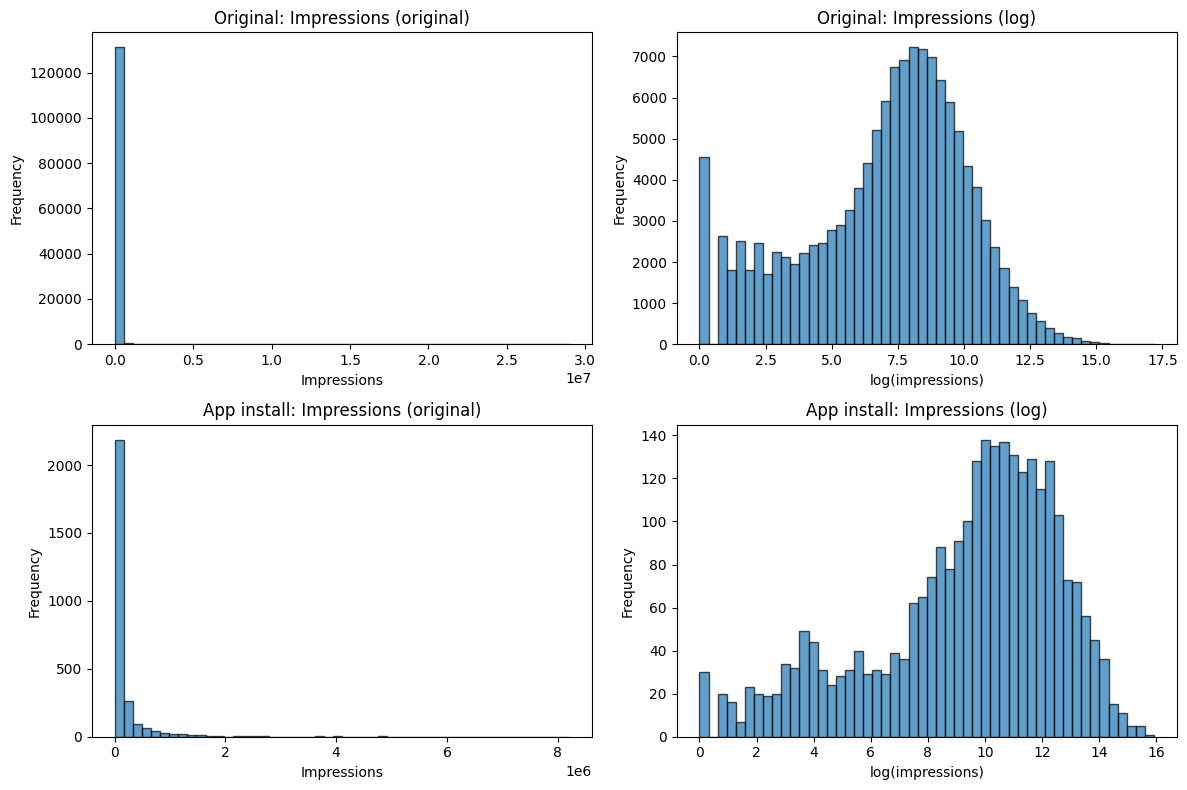

In [77]:
# Histograms of impressions: original and log (original | app_install)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for row, (df, title) in enumerate([(df_all_1201, 'Original'), (df_all_app_install_1201, 'App install')]):
    imp = df['impressions'].dropna()
    imp_pos = imp[imp > 0]
    axes[row, 0].hist(imp, bins=50, edgecolor='black', alpha=0.7)
    axes[row, 0].set_xlabel('Impressions')
    axes[row, 0].set_ylabel('Frequency')
    axes[row, 0].set_title(f'{title}: Impressions (original)')
    axes[row, 1].hist(np.log(imp_pos), bins=50, edgecolor='black', alpha=0.7)
    axes[row, 1].set_xlabel('log(impressions)')
    axes[row, 1].set_ylabel('Frequency')
    axes[row, 1].set_title(f'{title}: Impressions (log)')

plt.tight_layout()
plt.show()


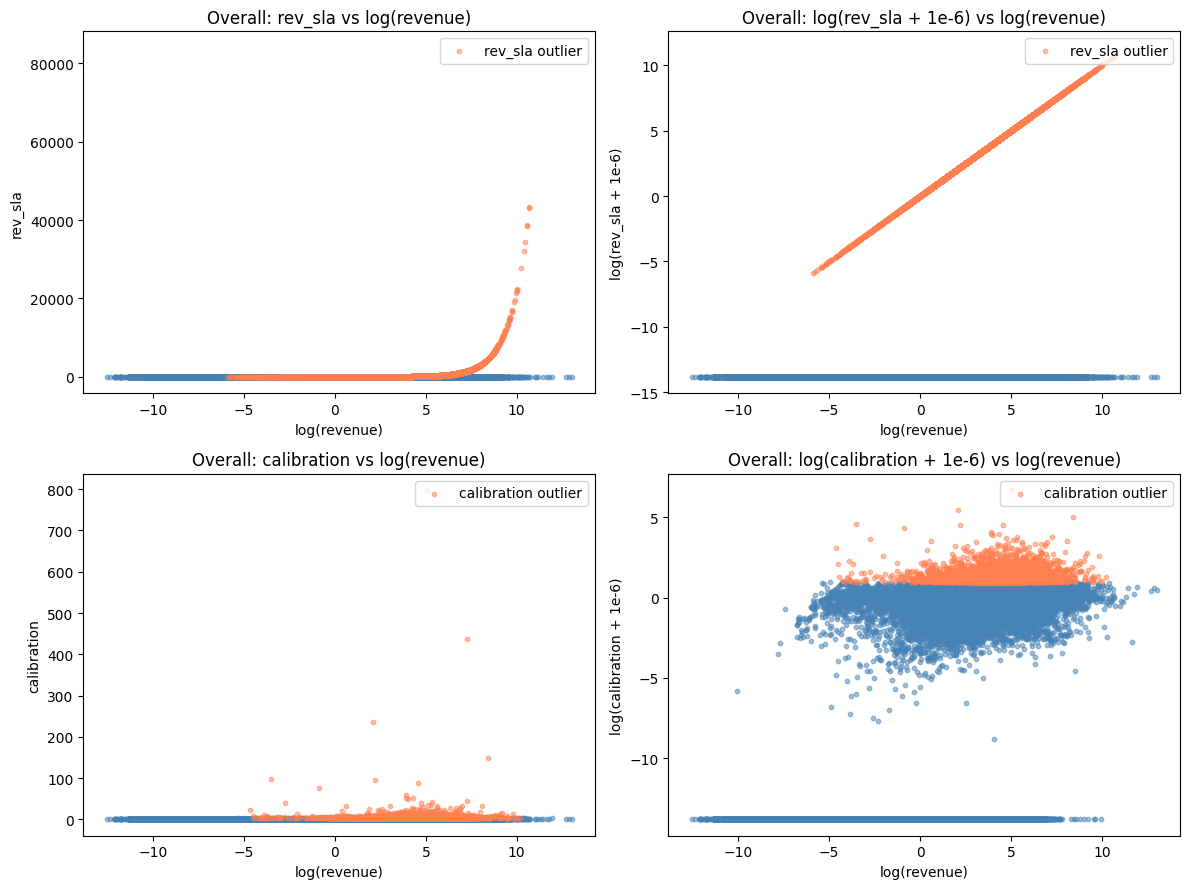

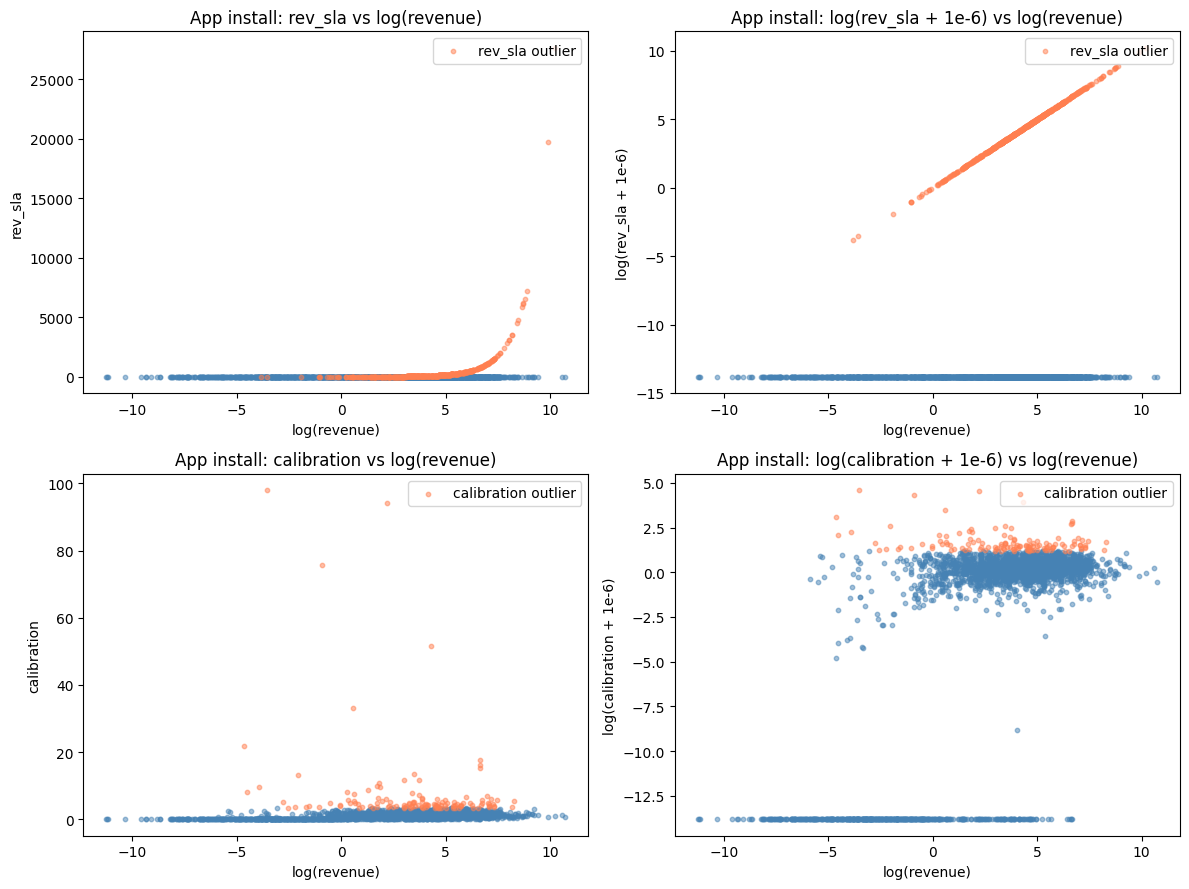

In [74]:
# 2x2 scatter: rev_sla and calibration vs log(revenue); outliers defined on raw values before log
# Only df_all_1201: Overall = full; App install = optimization_goal == 'App Install'
CAL_BIAS = 1e-6

for df, title in [(df_all_1201, 'Overall'), (df_all_app_install_1201, 'App install')]:
    plot_df = df.copy()
    plot_df['log_revenue'] = np.log(plot_df['revenue'])
    # Outliers on *raw* rev_sla:
    rs_pos = plot_df.loc[:, 'rev_sla']
    if len(rs_pos) > 0:
        q1_rs, q3_rs = np.percentile(rs_pos, [25, 75])
        iqr_rs = q3_rs - q1_rs
        lower_rs = q1_rs - 1.5 * iqr_rs
        upper_rs = q3_rs + 1.5 * iqr_rs
        rev_sla_outlier = ((plot_df['rev_sla'] < lower_rs) | (plot_df['rev_sla'] > upper_rs)).values
    else:
        rev_sla_outlier = np.zeros(len(plot_df), dtype=bool)
    # Outliers on *raw* calibration (before log); use finite values for IQR
    cal = plot_df['calibration'].replace(np.nan, 0)
    q1_cal, q3_cal = np.percentile(cal, [25, 75])
    iqr_cal = q3_cal - q1_cal
    lower_cal = q1_cal - 1.5 * iqr_cal
    upper_cal = q3_cal + 1.5 * iqr_cal
    cal_outlier = ((plot_df['calibration'] < lower_cal) | (plot_df['calibration'] > upper_cal)).values
  
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))
    # Top-left: rev_sla vs log(revenue)
    ax = axes[0, 0]
    ax.scatter(plot_df.loc[~rev_sla_outlier, 'log_revenue'], plot_df.loc[~rev_sla_outlier, 'rev_sla'], alpha=0.5, s=10, c='steelblue')
    ax.scatter(plot_df.loc[rev_sla_outlier, 'log_revenue'], plot_df.loc[rev_sla_outlier, 'rev_sla'], alpha=0.5, s=10, c='coral', label='rev_sla outlier')
    ax.set_xlabel('log(revenue)')
    ax.set_ylabel('rev_sla')
    ax.set_title(f'{title}: rev_sla vs log(revenue)')
    ax.legend(loc='upper right')
    # Top-right: log(rev_sla + 1e-6) vs log(revenue)
    ax = axes[0, 1]
    log_rs = np.log(plot_df['rev_sla'] + CAL_BIAS)
    ax.scatter(plot_df.loc[~rev_sla_outlier, 'log_revenue'], log_rs[~rev_sla_outlier], alpha=0.5, s=10, c='steelblue')
    ax.scatter(plot_df.loc[rev_sla_outlier, 'log_revenue'], log_rs[rev_sla_outlier], alpha=0.5, s=10, c='coral', label='rev_sla outlier')
    ax.set_xlabel('log(revenue)')
    ax.set_ylabel('log(rev_sla + 1e-6)')
    ax.set_title(f'{title}: log(rev_sla + 1e-6) vs log(revenue)')
    ax.legend(loc='upper right')
    # Bottom-left: Calibration vs log(revenue)
    ax = axes[1, 0]
    ax.scatter(plot_df.loc[~cal_outlier, 'log_revenue'], plot_df.loc[~cal_outlier, 'calibration'], alpha=0.5, s=10, c='steelblue')
    ax.scatter(plot_df.loc[cal_outlier, 'log_revenue'], plot_df.loc[cal_outlier, 'calibration'], alpha=0.5, s=10, c='coral', label='calibration outlier')
    ax.set_xlabel('log(revenue)')
    ax.set_ylabel('calibration')
    ax.set_title(f'{title}: calibration vs log(revenue)')
    ax.legend(loc='upper right')
    # Bottom-right: log(calibration + 1e-6) vs log(revenue)
    ax = axes[1, 1]
    cal_for_log = plot_df['calibration'].replace([np.inf, -np.inf], np.nan).fillna(0) + CAL_BIAS
    log_cal = np.log(cal_for_log)
    ax.scatter(plot_df.loc[~cal_outlier, 'log_revenue'], log_cal[~cal_outlier], alpha=0.5, s=10, c='steelblue')
    ax.scatter(plot_df.loc[cal_outlier, 'log_revenue'], log_cal[cal_outlier], alpha=0.5, s=10, c='coral', label='calibration outlier')
    ax.set_xlabel('log(revenue)')
    ax.set_ylabel('log(calibration + 1e-6)')
    ax.set_title(f'{title}: log(calibration + 1e-6) vs log(revenue)')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Import AB data

In [81]:
start_date = '2025-11-19'
end_date = '2025-12-06'
macrostate = 'AMALGAM'
treatment_bgid = 'BGID_17'
control_bgid = 'BGID_20'

df_ab = calibration_ab_data(start_date,
                         end_date,
                         macrostate,
                         treatment_bgid,
                         control_bgid,
                         gbb_filter = None,
                         spammy_filter=True,
                         house_ads_filter=True)

E0000 00:00:1771538568.222179 4406198 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [84]:
df_ab_agg= df_ab.groupby(['line_item_id', 'bid_strategy', 'optimization_goal', 'treatment_group']).agg(
                      {'impressions': 'sum',
                        'conversions': 'sum',
                        'predicted_conversions': 'sum',
                        'revenue': 'sum'}).reset_index()
df_ab_agg_wide = df_ab_agg.set_index(['line_item_id', 'bid_strategy', 'optimization_goal', 'treatment_group']).unstack().reset_index()
df_ab_agg_wide.columns = ['_'.join(map(str, col)).strip('_') for col in df_ab_agg_wide.columns.values]
df_ab_agg_wide.rename(columns={'line_item_id': 'line_item_id', 'bid_strategy': 'bid_strategy', 'optimization_goal': 'optimization_goal'}, inplace=True)
df_ab_agg_wide = df_ab_agg_wide.fillna(0)

In [86]:
ab_results = calibration_analysis(df_ab_agg_wide, threshold =0, confidence_interval = 95)
ab_results.head()

,optimization_goal,cali_t,cali_c,cali_d,cali_d_se,cali_d_ci,cali_d_ci_width,cali_d_ci_width_rel,perc_rev_sla_t,perc_rev_sla_c,perc_rev_sla_d,perc_rev_sla_d_se,perc_rev_sla_d_ci,perc_rev_sla_d_ci_width,perc_rev_sla_d_ci_width_rel
0,Overall,"0.886 (0.863, 0.908)","0.884 (0.861, 0.907)",-0.002,0.017,"(-0.034, 0.031)",0.0648,39.2118,"49.71% (47.90%, 51.52%)","49.14% (47.32%, 50.96%)",0.57%,1.31%,"(-1.99%, 3.13%)",0.0512,8.9637
1,PIXEL_PURCHASE,"1.025 (1.007, 1.043)","1.026 (1.009, 1.044)",-0.001,0.013,"(-0.027, 0.024)",0.0504,34.0227,"39.47% (36.35%, 42.59%)","38.92% (35.83%, 42.01%)",0.55%,2.24%,"(-3.84%, 4.94%)",0.0878,15.9673
2,SWIPES,"1.005 (1.003, 1.008)","1.005 (1.003, 1.007)",0.000,0.002,"(-0.003, 0.004)",0.0066,15.6317,"91.17% (90.08%, 92.26%)","91.11% (90.03%, 92.20%)",0.05%,0.78%,"(-1.48%, 1.59%)",0.0308,56.1116
3,VIDEO_VIEWS,"0.999 (0.997, 1.000)","0.998 (0.997, 1.000)",-0.000,0.001,"(-0.003, 0.002)",0.0045,9.5364,"99.57% (nan%, nan%)","99.54% (nan%, nan%)",0.03%,nan%,"(nan%, nan%)",NaN,NaN
4,APP_INSTALLS_7_0,"0.844 (0.786, 0.902)","0.855 (0.753, 0.957)",0.011,0.060,"(-0.106, 0.128)",0.2347,21.3896,"38.48% (30.20%, 46.76%)","37.38% (29.24%, 45.52%)",1.10%,5.92%,"(-10.51%, 12.71%)",0.2322,21.0801


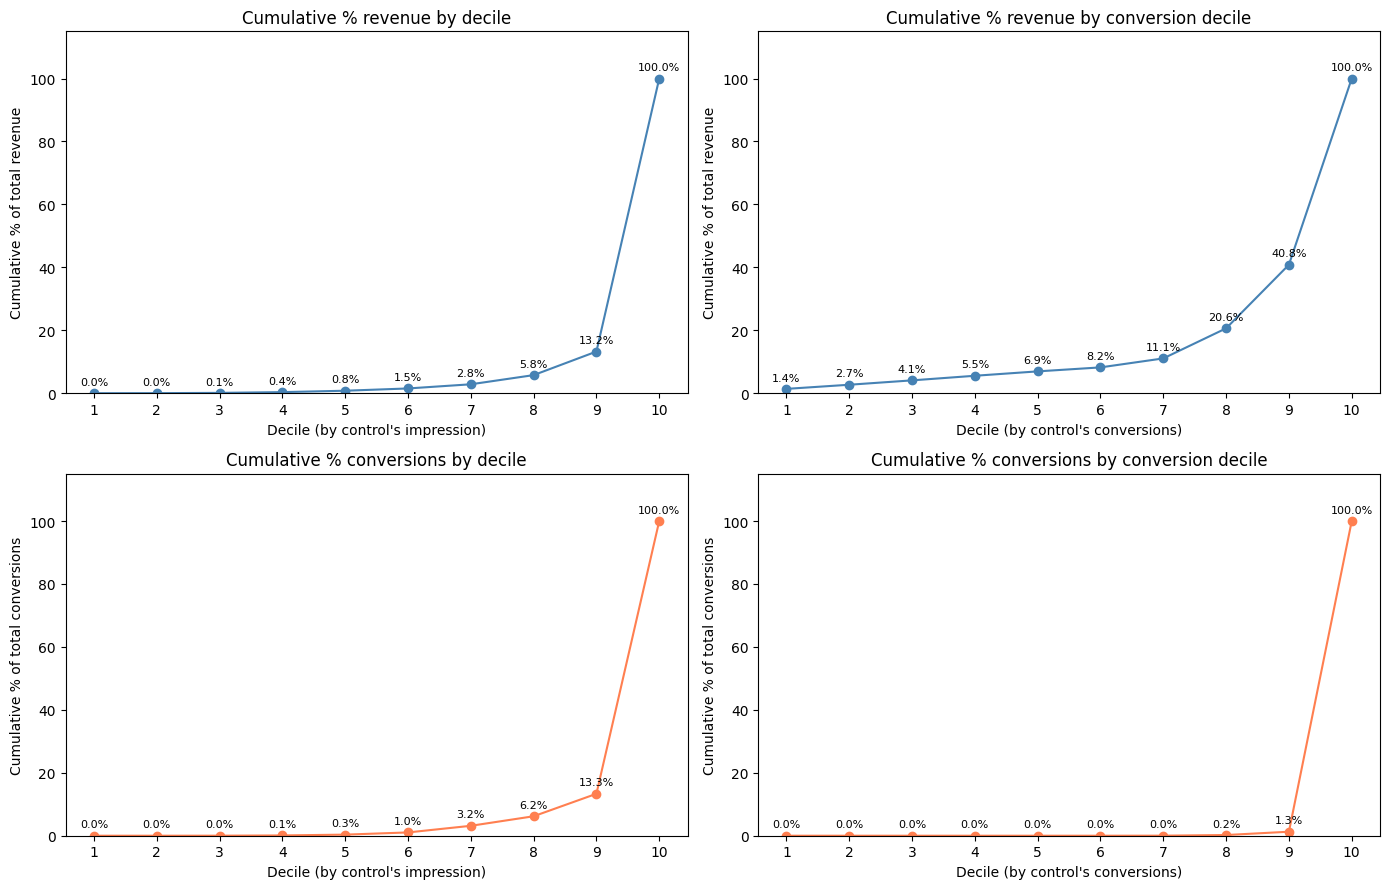

In [94]:
def plot_cumulative_deciles(df, fig_title_prefix=''):
    df = df.copy()
    df['decile_imp']  = pd.qcut(df['impressions_control'].rank(method='first'),  q=10, labels=False) + 1
    df['decile_conv'] = pd.qcut(df['conversions_control'].rank(method='first'), q=10, labels=False) + 1

    fig, axes = plt.subplots(2, 2, figsize=(14, 9))

    configs = [
        (axes[0, 0], 'decile_imp',  'revenue_control',     'steelblue', 'Cumulative % of total revenue',     "Cumulative % revenue by decile"),
        (axes[0, 1], 'decile_conv', 'revenue_control',     'steelblue', 'Cumulative % of total revenue',     "Cumulative % revenue by conversion decile"),
        (axes[1, 0], 'decile_imp',  'conversions_control', 'coral',     'Cumulative % of total conversions', "Cumulative % conversions by decile"),
        (axes[1, 1], 'decile_conv', 'conversions_control', 'coral',     'Cumulative % of total conversions', "Cumulative % conversions by conversion decile"),
    ]

    for ax, decile_col, metric_col, color, ylabel, title in configs:
        grp = df.groupby(decile_col)[metric_col].sum().reset_index().sort_values(decile_col)
        grp['cum_pct'] = grp[metric_col].cumsum() / grp[metric_col].sum() * 100

        ax.plot(grp[decile_col], grp['cum_pct'], marker='o', color=color)
        for _, row in grp.iterrows():
            ax.annotate(f"{row['cum_pct']:.1f}%",
                        xy=(row[decile_col], row['cum_pct']),
                        xytext=(0, 6), textcoords='offset points',
                        ha='center', fontsize=8)
        ax.set_xlabel("Decile (by control's impression)" if 'imp' in decile_col else "Decile (by control's conversions)")
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(range(1, 11))
        ax.set_ylim(0, 115)

    if fig_title_prefix:
        plt.suptitle(fig_title_prefix, y=1.01, fontsize=13)
    plt.tight_layout()
    plt.show()

plot_cumulative_deciles(df_ab_agg_wide)


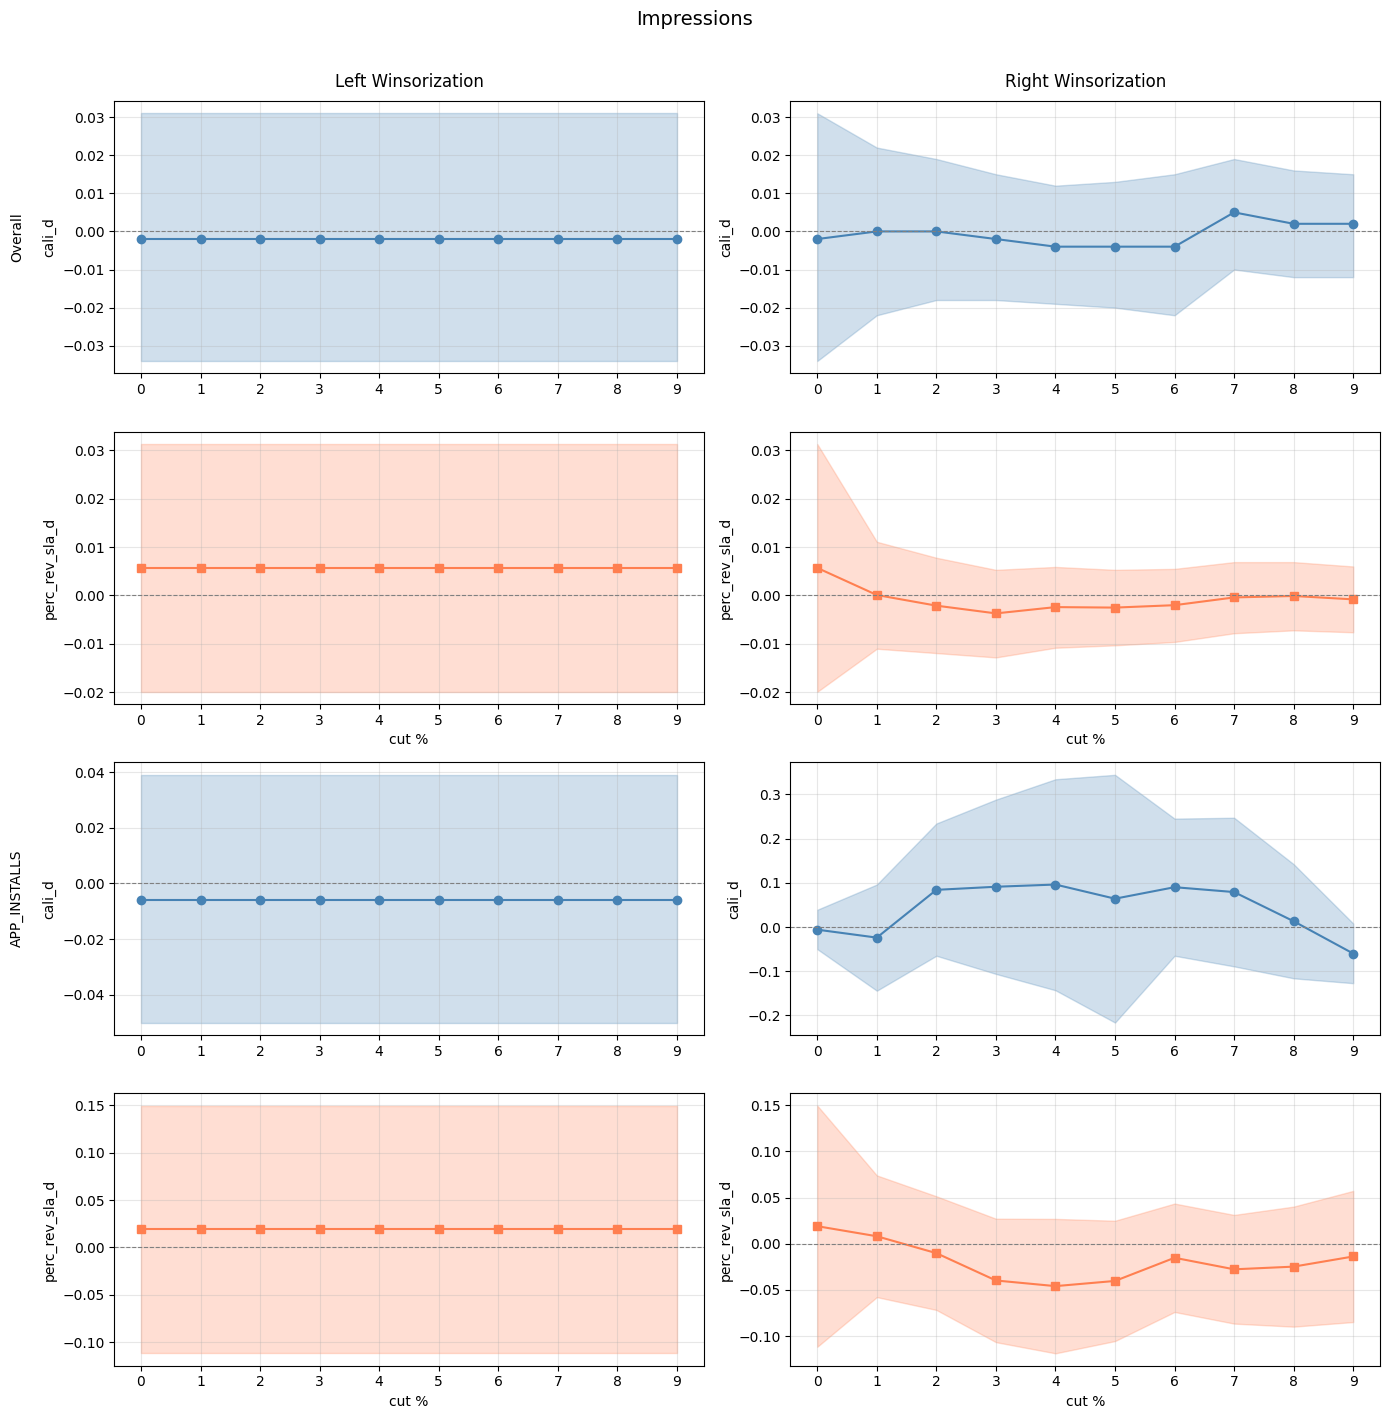

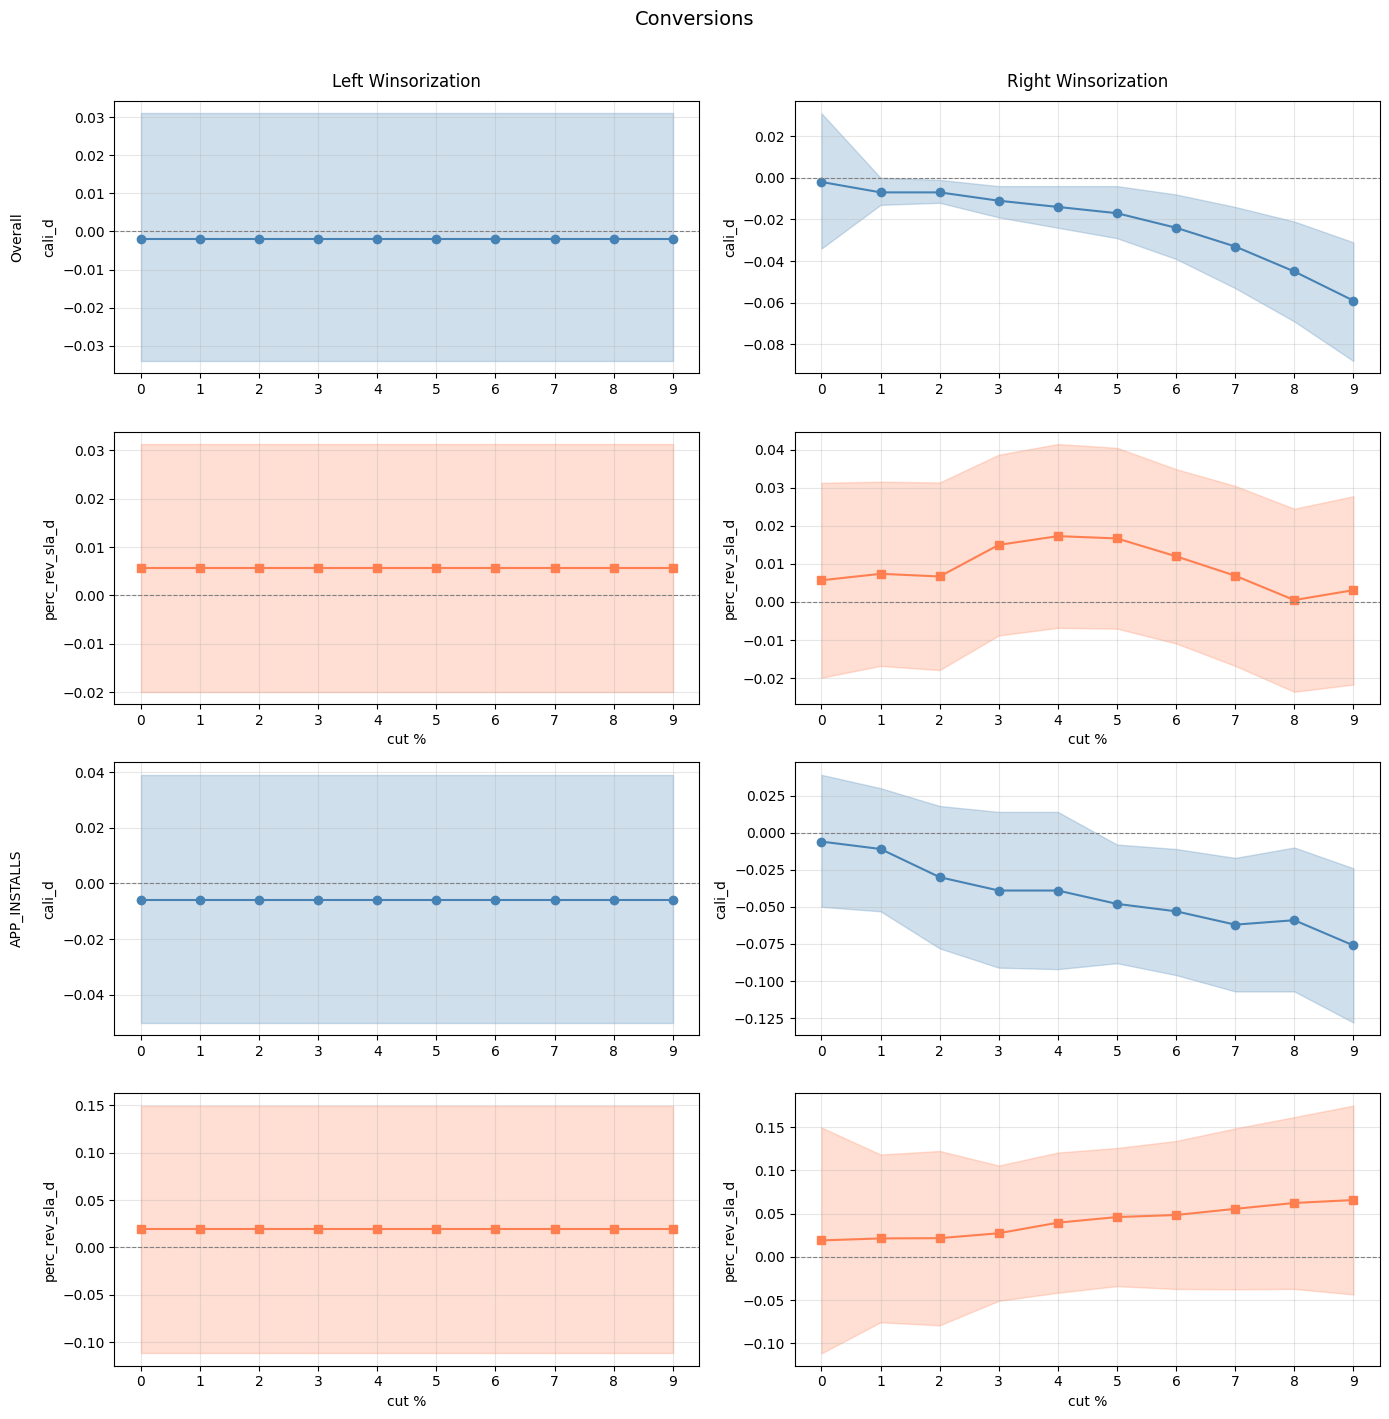

In [97]:
# Winsorization sensitivity charts
# Collects point estimates + CI bounds at each cut level, then plots like the reference image.

def _parse_pct_str(s):
    """Parse '1.23%' or '-0.45%' to float (fractional)."""
    return float(str(s).strip().replace('%', '')) / 100

def collect_winsorization_estimates(df_wide, dimension_col, directions, pct_levels,
                                    goals_to_keep=None, threshold=0, confidence_interval=95):
    """
    Same loop as winsorization_revenue_ci_summary but also returns point estimates
    and CI bounds needed for line + shaded-band plots.
    """
    if goals_to_keep is None:
        goals_to_keep = ['Overall']
    rows = []
    df_dim = df_wide.dropna(subset=[dimension_col])
    for direction in directions:
        for pct in pct_levels:
            w = winsorize_by_dimension(df_dim, dimension_col, pct, direction=direction)
            if len(w) < 2:
                continue
            m = calibration_analysis(w, threshold=threshold, confidence_interval=confidence_interval)
            if 'optimization_goal' not in m.columns:
                m = m.copy()
                m['optimization_goal'] = 'Overall'
            m = m[m['optimization_goal'].isin(goals_to_keep)]
            for _, r in m.iterrows():
                cali_ci_l, cali_ci_r = r['cali_d_ci']
                prs_ci_l = _parse_pct_str(r['perc_rev_sla_d_ci'][0])
                prs_ci_r = _parse_pct_str(r['perc_rev_sla_d_ci'][1])
                rows.append({
                    'direction':          direction,
                    'pct_cut':            pct,
                    'optimization_goal':  r['optimization_goal'],
                    'cali_d':             r['cali_d'],
                    'cali_d_ci_l':        cali_ci_l,
                    'cali_d_ci_r':        cali_ci_r,
                    'perc_rev_sla_d':     _parse_pct_str(r['perc_rev_sla_d']),
                    'perc_rev_sla_d_ci_l': prs_ci_l,
                    'perc_rev_sla_d_ci_r': prs_ci_r,
                })
    return pd.DataFrame(rows)


def plot_winsorization_sensitivity(df_wide, dimension_cols, directions, pct_levels,
                                   goals_to_keep=None, threshold=0, confidence_interval=95):
    """
    For each dimension: one figure with layout matching the reference image.
      Columns = directions (left / right)
      Row groups = optimization goals (Overall, App Install, …)
        Each group = 2 subplots stacked: cali_d (blue) on top, perc_rev_sla_d (coral) below
    """
    if goals_to_keep is None:
        goals_to_keep = ['Overall']

    for dim_col in dimension_cols:
        df_est = collect_winsorization_estimates(
            df_wide, dim_col, directions, pct_levels,
            goals_to_keep=goals_to_keep,
            threshold=threshold, confidence_interval=confidence_interval
        )
        if df_est.empty:
            print(f"No data for {dim_col}")
            continue

        n_goals = len(goals_to_keep)
        n_rows = n_goals * 2          # 2 metrics per goal
        n_cols = len(directions)

        fig, axes = plt.subplots(n_rows, n_cols,
                                 figsize=(7 * n_cols, 3.5 * n_rows),
                                 squeeze=False)
        dim_label = dim_col.replace('_control', '').replace('_', ' ').title()
        fig.suptitle(dim_label, fontsize=14, y=1.01)

        for col_idx, direction in enumerate(directions):
            df_dir = df_est[df_est['direction'] == direction]

            # Direction header as column title on first goal row
            axes[0, col_idx].set_title(
                f"{'Left' if direction == 'left' else 'Right'} Winsorization",
                fontsize=12, pad=10
            )

            for goal_idx, goal in enumerate(goals_to_keep):
                df_g = df_dir[df_dir['optimization_goal'] == goal].sort_values('pct_cut')
                row_cali = goal_idx * 2
                row_prs  = goal_idx * 2 + 1

                ax_c = axes[row_cali, col_idx]
                ax_p = axes[row_prs,  col_idx]

                # Goal label on left edge of cali subplot
                if col_idx == 0:
                    ax_c.set_ylabel(f"{goal}\n\ncali_d")
                else:
                    ax_c.set_ylabel('cali_d')

                if not df_g.empty:
                    ax_c.plot(df_g['pct_cut'], df_g['cali_d'], marker='o', color='steelblue')
                    ax_c.fill_between(df_g['pct_cut'],
                                      df_g['cali_d_ci_l'], df_g['cali_d_ci_r'],
                                      alpha=0.25, color='steelblue')
                    ax_p.plot(df_g['pct_cut'], df_g['perc_rev_sla_d'], marker='s', color='coral')
                    ax_p.fill_between(df_g['pct_cut'],
                                      df_g['perc_rev_sla_d_ci_l'], df_g['perc_rev_sla_d_ci_r'],
                                      alpha=0.25, color='coral')

                for ax in (ax_c, ax_p):
                    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
                    ax.grid(True, alpha=0.3)
                    ax.set_xticks(pct_levels)

                ax_p.set_ylabel('perc_rev_sla_d')
                ax_p.set_xlabel('cut %')

        plt.tight_layout()
        plt.show()


# --- Run ---
pct_levels    = np.arange(0, 10)
dimension_cols = ['impressions_control', 'conversions_control']
directions     = ['left', 'right']
goals_to_keep  = ['Overall', 'APP_INSTALLS']

plot_winsorization_sensitivity(
    df_ab_agg_wide,
    dimension_cols=dimension_cols,
    directions=directions,
    pct_levels=pct_levels,
    goals_to_keep=goals_to_keep,
    threshold=0,
    confidence_interval=95
)

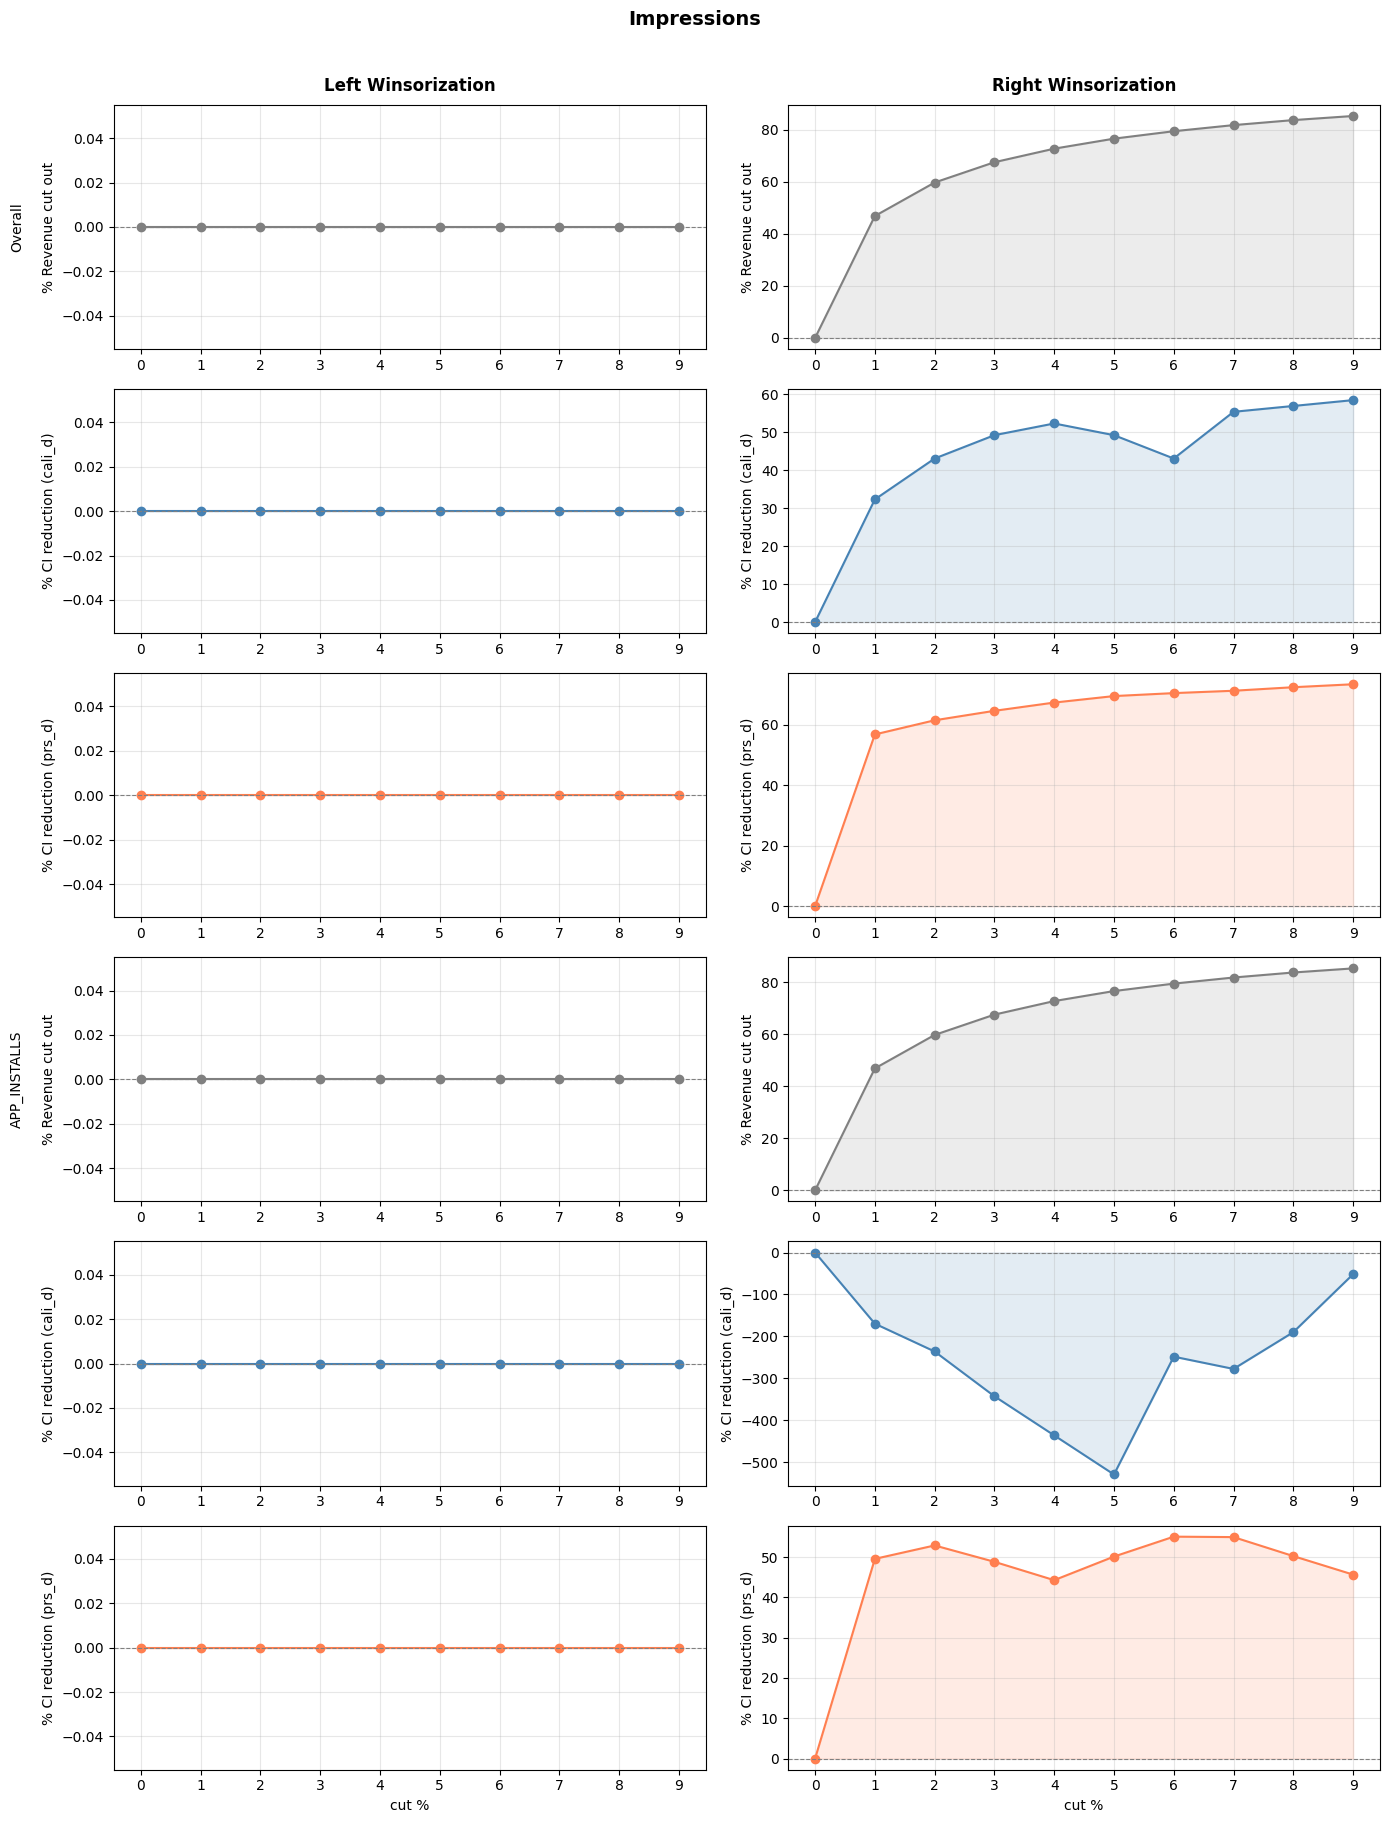

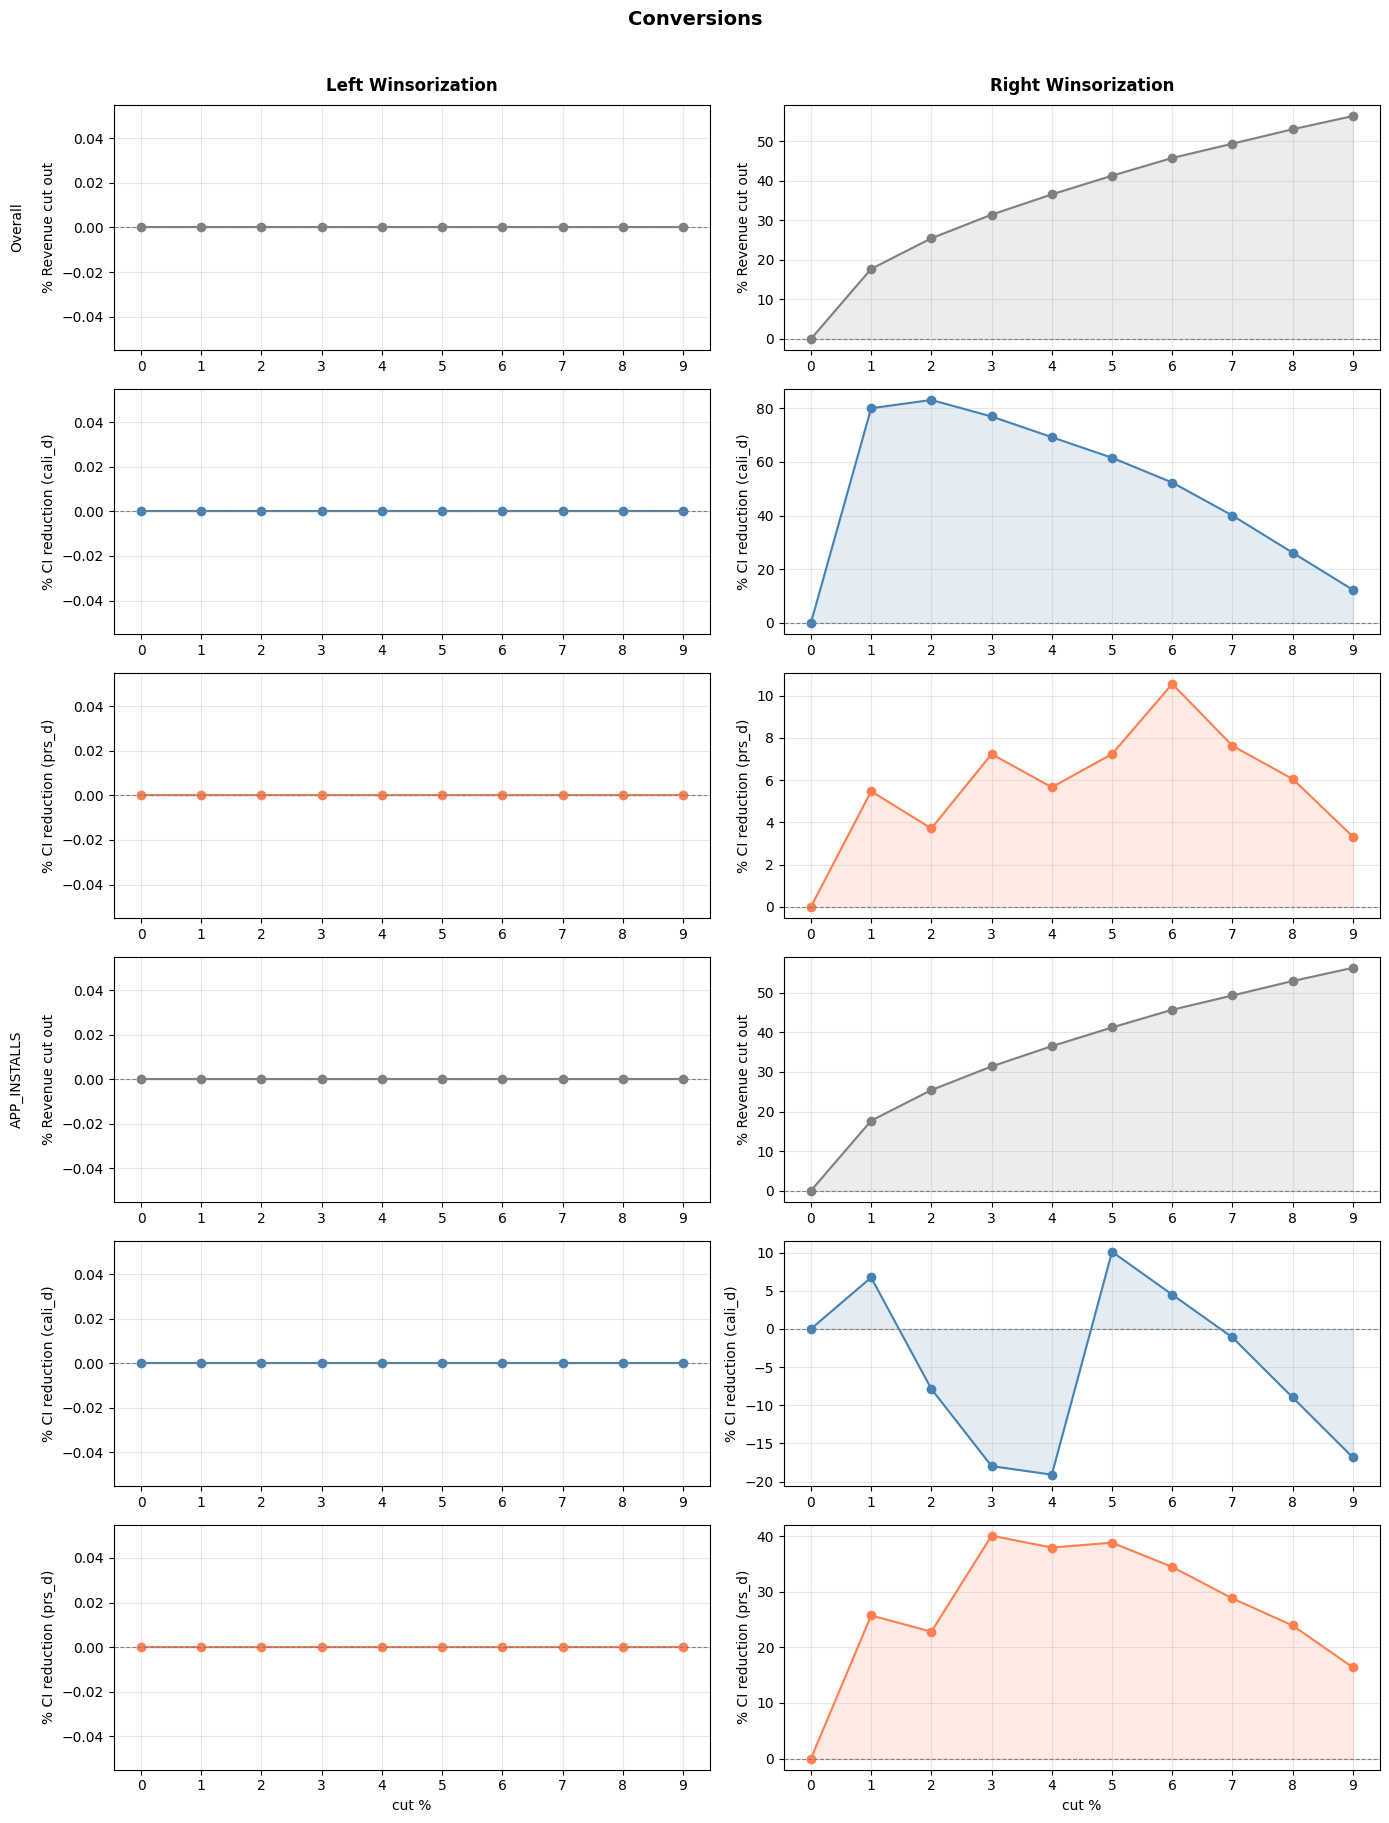

In [96]:
# Revenue cut-out % and variance reduction % across winsorization levels
# Uses winsorization_revenue_ci_summary directly (it already computes these)

ws = winsorization_revenue_ci_summary(
    df_ab_agg_wide,
    dimension_cols=dimension_cols,
    directions=directions,
    pct_levels=pct_levels,
    goals_to_keep=goals_to_keep,
    threshold=0,
    confidence_interval=95
)

def plot_winsorization_tradeoff(ws, dimension_cols, directions, goals_to_keep):
    """
    For each dimension: one figure.
    Columns = directions, row groups = goals.
    Each group has 3 stacked subplots:
      1. % revenue cut out  (grey)
      2. % CI width reduction for cali_d  (blue)
      3. % CI width reduction for perc_rev_sla_d  (coral)
    """
    metrics = [
        ('revenue_cut_out_pct',           '% Revenue cut out',         'grey'),
        ('cali_d_ci_reduction_pct',       '% CI reduction (cali_d)',   'steelblue'),
        ('perc_rev_sla_d_ci_reduction_pct','% CI reduction (prs_d)',   'coral'),
    ]

    for dim_col in dimension_cols:
        df_dim = ws[ws['dimension'] == dim_col]
        if df_dim.empty:
            print(f"No data for {dim_col}")
            continue

        n_goals   = len(goals_to_keep)
        n_metrics = len(metrics)
        n_rows    = n_goals * n_metrics
        n_cols    = len(directions)

        dim_label = dim_col.replace('_control', '').replace('_', ' ').title()
        fig, axes = plt.subplots(n_rows, n_cols,
                                 figsize=(7 * n_cols, 3 * n_rows),
                                 squeeze=False)
        fig.suptitle(dim_label, fontsize=14, fontweight='bold', y=1.01)

        for col_idx, direction in enumerate(directions):
            df_dir = df_dim[df_dim['direction'] == direction]

            axes[0, col_idx].set_title(
                f"{'Left' if direction == 'left' else 'Right'} Winsorization",
                fontsize=12, fontweight='bold', pad=10
            )

            for goal_idx, goal in enumerate(goals_to_keep):
                df_g = df_dir[df_dir['optimization_goal'] == goal].sort_values('pct_cut')

                for m_idx, (col, ylabel, color) in enumerate(metrics):
                    row = goal_idx * n_metrics + m_idx
                    ax  = axes[row, col_idx]

                    if col_idx == 0 and m_idx == 0:
                        ax.set_ylabel(f"{goal}\n\n{ylabel}")
                    else:
                        ax.set_ylabel(ylabel)

                    if not df_g.empty:
                        ax.plot(df_g['pct_cut'], df_g[col],
                                marker='o', color=color, linewidth=1.5)
                        ax.fill_between(df_g['pct_cut'], 0, df_g[col],
                                        alpha=0.15, color=color)

                    ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
                    ax.grid(True, alpha=0.3)
                    ax.set_xticks(df_g['pct_cut'].values if not df_g.empty else [])

                    if row == n_rows - 1:
                        ax.set_xlabel('cut %')

        plt.tight_layout()
        plt.show()

plot_winsorization_tradeoff(ws, dimension_cols, directions, goals_to_keep)

In [ ]:
start_date = '2025-12-15'
end_date   = '2026-01-18'
df_ts = all_traffic_data(start_date, end_date)

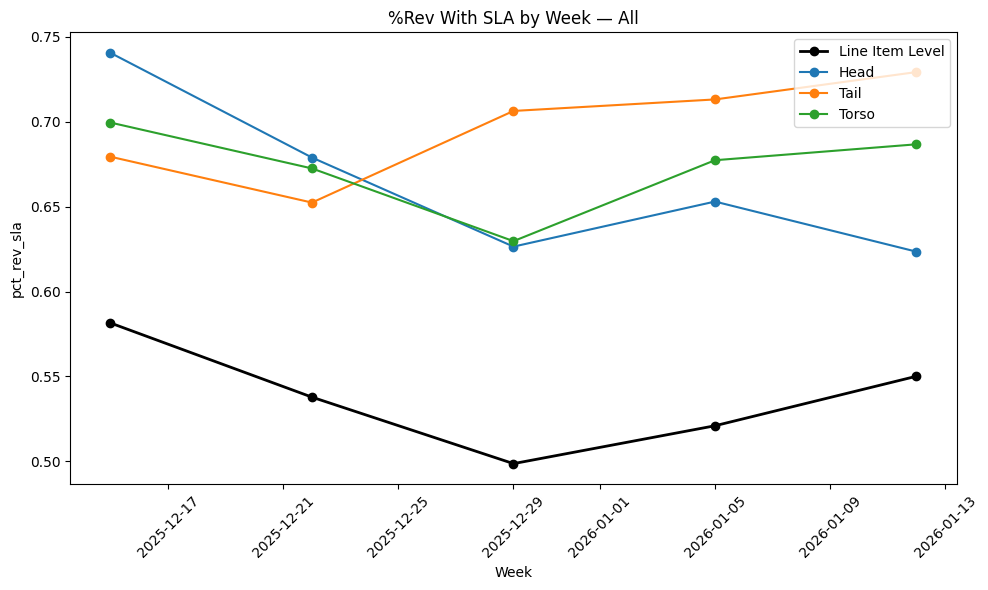

CV of pct_rev_sla — All


,label,mean,std,cv,cv_pct
0,Line Item Level,0.5378,0.0311,0.0579,5.7890
1,Head,0.6645,0.0481,0.0724,7.2399
2,Tail,0.6961,0.0304,0.0436,4.3605
3,Torso,0.6731,0.0264,0.0392,3.9214


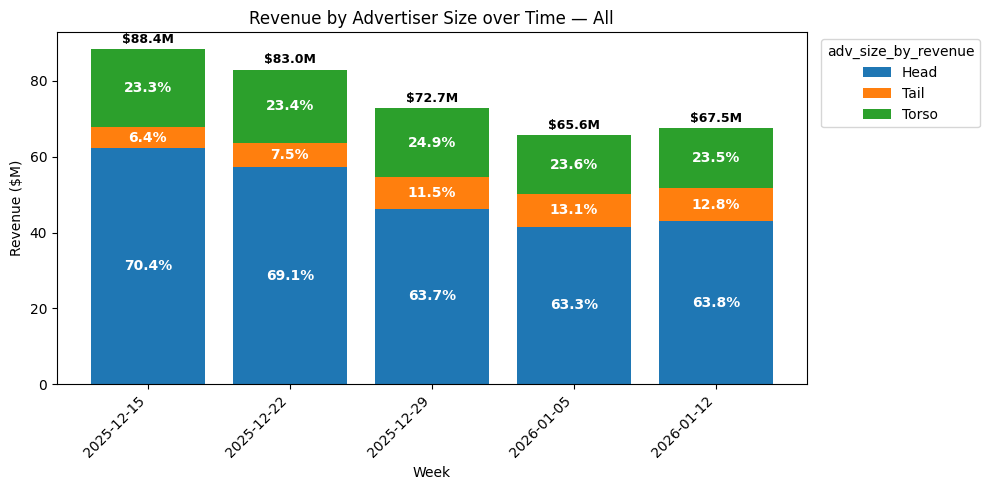

In [129]:
def build_ts_dataframes(df_ts, gbb_filter=None):
    df = df_ts.copy()
    if gbb_filter is not None:
        df = df[df['optimization_goal'] == gbb_filter]

    def _add_sla_cols(df_in, group_cols):
        agg = (
            df_in.groupby(group_cols)
            .agg(
                conversions=('conversions', 'sum'),
                predicted_conversions=('predicted_conversions', 'sum'),
                revenue=('revenue', 'sum'),
            )
            .reset_index()
        )
        agg['calibration'] = np.where(
            agg['conversions'] == 0, 0,
            agg['predicted_conversions'] / agg['conversions'],
        )
        agg['sla_flag'] = np.where(
            (agg['calibration'] > 0.8) & (agg['calibration'] < 1.2), 1, 0
        )
        agg['rev_sla'] = agg['sla_flag'] * agg['revenue']
        return agg

    # Per account × week
    df_ts_by_acct = _add_sla_cols(df, ['week', 'ad_account_id', 'adv_size_by_revenue'])

    df_ts_by_acct_agg = (
        df_ts_by_acct.groupby(['week', 'adv_size_by_revenue'])
        .agg(
            conversions=('conversions', 'sum'),
            predicted_conversions=('predicted_conversions', 'sum'),
            revenue=('revenue', 'sum'),
            rev_sla=('rev_sla', 'sum'),
        )
        .reset_index()
    )
    df_ts_by_acct_agg['pct_rev_sla'] = df_ts_by_acct_agg['rev_sla'] / df_ts_by_acct_agg['revenue']

    # Overall: line_item level → weekly
    df_ts_overall = _add_sla_cols(df, ['week', 'line_item_id'])

    df_ts_overall_agg = (
        df_ts_overall.groupby('week')
        .agg(
            conversions=('conversions', 'sum'),
            predicted_conversions=('predicted_conversions', 'sum'),
            revenue=('revenue', 'sum'),
            rev_sla=('rev_sla', 'sum'),
        )
        .reset_index()
    )
    df_ts_overall_agg['pct_rev_sla'] = df_ts_overall_agg['rev_sla'] / df_ts_overall_agg['revenue']

    return df_ts_by_acct, df_ts_by_acct_agg, df_ts_overall, df_ts_overall_agg


def plot_ts_analysis(df_ts_by_acct_agg, df_ts_overall_agg, gbb_filter=None):
    suffix = f' — {gbb_filter}' if gbb_filter else ' — All'

    # ── 8. pct_rev_sla by week ───────────────────────────────────────────────
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        df_ts_overall_agg['week'], df_ts_overall_agg['pct_rev_sla'],
        marker='o', linewidth=2, color='black', label='Line Item Level',
    )
    for adv_size, grp in df_ts_by_acct_agg.groupby('adv_size_by_revenue'):
        grp = grp.sort_values('week')
        ax.plot(grp['week'], grp['pct_rev_sla'], marker='o', linewidth=1.5, label=adv_size)
    ax.set_xlabel('Week')
    ax.set_ylabel('pct_rev_sla')
    ax.set_title(f'%Rev With SLA by Week{suffix}')
    ax.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ── 9. CV table ──────────────────────────────────────────────────────────
    rows_cv = []
    prs_overall = df_ts_overall_agg['pct_rev_sla']
    mean_o, std_o = prs_overall.mean(), prs_overall.std()
    rows_cv.append({
        'label':  'Line Item Level',
        'mean':   mean_o,
        'std':    std_o,
        'cv':     std_o / mean_o if mean_o != 0 else np.nan,
        'cv_pct': std_o / mean_o * 100 if mean_o != 0 else np.nan,
    })
    for adv_size, grp in df_ts_by_acct_agg.groupby('adv_size_by_revenue'):
        prs = grp['pct_rev_sla']
        mean_a, std_a = prs.mean(), prs.std()
        rows_cv.append({
            'label':  adv_size,
            'mean':   mean_a,
            'std':    std_a,
            'cv':     std_a / mean_a if mean_a != 0 else np.nan,
            'cv_pct': std_a / mean_a * 100 if mean_a != 0 else np.nan,
        })
    print(f'CV of pct_rev_sla{suffix}')
    display(pd.DataFrame(rows_cv).round(4))

    # ── 10. Revenue stacked bar by adv_size ──────────────────────────────────
    df_plot_rev = df_ts_by_acct_agg.copy()
    rev_pivot = df_plot_rev.pivot_table(
        index='week', columns='adv_size_by_revenue', values='revenue', aggfunc='sum'
    ).fillna(0).sort_index()
    weekly_total = rev_pivot.sum(axis=1)
    pct_pivot = rev_pivot.div(weekly_total, axis=0) * 100
    rev_pivot_m = rev_pivot / 1e6
    weekly_total_m = rev_pivot_m.sum(axis=1).values
    weeks = [str(w) for w in rev_pivot_m.index]
    adv_sizes = rev_pivot_m.columns.tolist()
    colors = plt.cm.tab10.colors

    fig, ax = plt.subplots(figsize=(10, 5))
    bottoms = np.zeros(len(weeks))
    for i, adv_size in enumerate(adv_sizes):
        heights = rev_pivot_m[adv_size].values
        pcts = pct_pivot[adv_size].values
        bars = ax.bar(weeks, heights, bottom=bottoms, label=adv_size, color=colors[i % len(colors)])
        for bar, pct, bot in zip(bars, pcts, bottoms):
            if pct >= 3:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bot + bar.get_height() / 2,
                    f'{pct:.1f}%',
                    ha='center', va='center', fontsize=10, color='white', fontweight='bold',
                )
        bottoms = bottoms + heights
    for x, total in zip(weeks, weekly_total_m):
        ax.text(x, total + 0.01 * weekly_total_m.max(), f'${total:.1f}M',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    ax.set_xlabel('Week')
    ax.set_ylabel('Revenue ($M)')
    ax.set_title(f'Revenue by Advertiser Size over Time{suffix}')
    ax.legend(title='adv_size_by_revenue', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# ── Run with all data (no filter) ────────────────────────────────────────────
df_ts_by_acct, df_ts_by_acct_agg, df_ts_overall, df_ts_overall_agg = build_ts_dataframes(df_ts)
plot_ts_analysis(df_ts_by_acct_agg, df_ts_overall_agg)


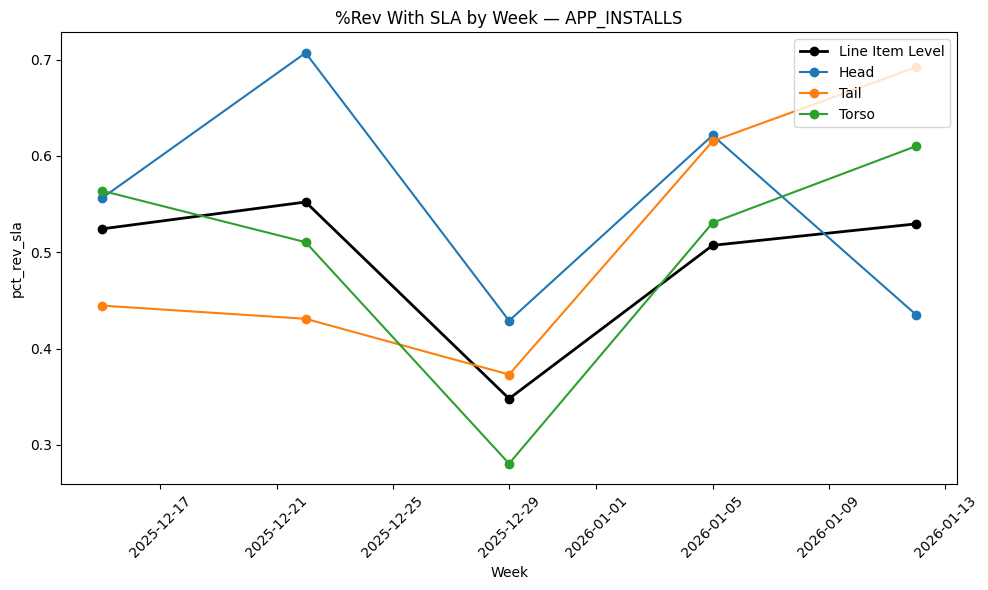

CV of pct_rev_sla — APP_INSTALLS


,label,mean,std,cv,cv_pct
0,Line Item Level,0.4923,0.0822,0.1669,16.6942
1,Head,0.5498,0.1200,0.2183,21.8312
2,Tail,0.5113,0.1356,0.2652,26.5185
3,Torso,0.4991,0.1278,0.2561,25.6098


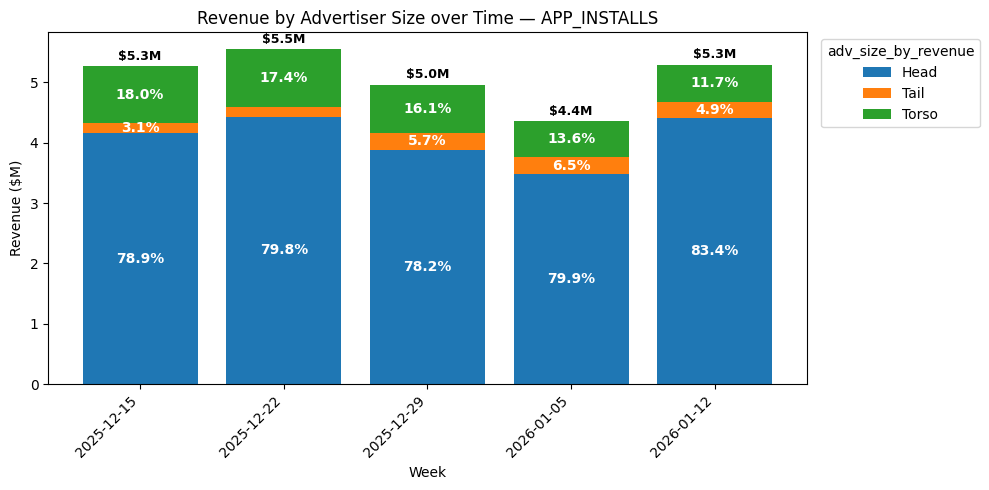

In [130]:
df_ts_by_acct, df_ts_by_acct_agg, df_ts_overall, df_ts_overall_agg = build_ts_dataframes(df_ts, gbb_filter='APP_INSTALLS')
plot_ts_analysis(df_ts_by_acct_agg, df_ts_overall_agg, gbb_filter='APP_INSTALLS')

In [124]:
df_ts['optimization_goal'].unique()

array(['APP_PURCHASE', 'PIXEL_SIGNUP', 'PIXEL_PAGE_VIEW', 'ENGAGED_VIEW',
       'APP_REENGAGE_PURCHASE', 'APP_REENGAGE_OPEN', 'PIXEL_ADD_TO_CART',
       'APP_INSTALLS', 'APP_INSTALLS_7_0', 'VIDEO_VIEWS_15_SEC',
       'STORY_OPENS', 'SWIPES', 'APP_SIGNUP', 'PIXEL_PURCHASE',
       'APP_ADD_TO_CART', 'PIXEL_PURCHASE_VO', 'USES', 'APP_PURCHASE_VO',
       'APP_ACHIEVEMENT_UNLOCKED', 'VIDEO_VIEWS', 'LANDING_PAGE_VIEW',
       'LEAD_FORM_SUBMISSIONS'], dtype=object)